In [1]:
# =======================
# 0) Imports & Config
# =======================
import os, cv2, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from zoneinfo import ZoneInfo
from scipy.ndimage import distance_transform_edt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, Concatenate

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

import wandb
from wandb.integration.keras import WandbCallback
from sklearn.model_selection import train_test_split

2025-08-20 10:47:56.805015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755686877.173228      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755686877.280076      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Hyperparams
IMG_SIZE = 512
BATCH_SIZE = 8
EPOCH = 150
learning_rate = 1e-4
weight_decay = 1e-5
optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

# Paths
file_path = "/kaggle/input/d/hntrnnggia/btxrd-v1/classification.xlsx"
image_path = "/kaggle/input/d/hntrnnggia/btxrd-v1/images"
mask_path  = "/kaggle/input/d/hntrnnggia/btxrd-v1/masks"
dist_map_save_path = "/kaggle/working/distance_maps/"
os.makedirs(dist_map_save_path, exist_ok=True)

print("==> Load Excel")
df = pd.read_excel(file_path)

I0000 00:00:1755686898.363357      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755686898.364101      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


==> Load Excel


In [3]:
# =======================
# 1) Distance Map Builder
# =======================
def create_distance_map_np(mask_np):
    binary_mask = (mask_np > 0).astype(np.uint8)
    fg = binary_mask
    bg = 1 - fg
    dist_out = distance_transform_edt(bg)
    dist_in  = distance_transform_edt(fg)
    dist_map = dist_out - dist_in
    max_val = np.max(np.abs(dist_map))
    if max_val > 0: 
        dist_map = dist_map / max_val
    return dist_map.astype(np.float32)

df_with_mask = df[df["mask_flag"]==1].copy()
print(f"Tạo & lưu distance maps cho {len(df_with_mask)} ảnh...")
for _, row in tqdm(df_with_mask.iterrows(), total=df_with_mask.shape[0]):
    image_id = row["image_id"]
    base = os.path.splitext(image_id)[0]
    cur_mask_path = os.path.join(mask_path, f"{base}.png")
    mask_img = cv2.imread(cur_mask_path, cv2.IMREAD_GRAYSCALE)
    if mask_img is None: 
        continue
    mask_img = cv2.resize(mask_img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    dist_map = create_distance_map_np(mask_img)
    np.save(os.path.join(dist_map_save_path, f"{base}.npy"), dist_map)
print(f"✅ Tiền xử lý xong. Saved at: {dist_map_save_path}")



Tạo & lưu distance maps cho 1867 ảnh...


100%|██████████| 1867/1867 [01:31<00:00, 20.44it/s]

✅ Tiền xử lý xong. Saved at: /kaggle/working/distance_maps/


In [4]:
# =======================
# 2) Split & Path Columns
# =======================
df_t = df[df["mask_flag"]==1].copy()
df_train, df_temp = train_test_split(df_t, test_size=0.3, random_state=42, shuffle=True, stratify=df_t["tumor_type"])
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, shuffle=True, stratify=df_temp["tumor_type"])
print("Split sizes -> Train:", len(df_train), "Valid:", len(df_valid), "Test:", len(df_test))

def add_paths(df_):
    base_name = lambda x: os.path.splitext(x)[0]
    df_ = df_.copy()
    df_["image_path"] = df_["image_id"].apply(lambda x: os.path.join(image_path, f"{base_name(x)}.jpg"))
    df_["mask_path"]  = df_["image_id"].apply(lambda x: os.path.join(mask_path,  f"{base_name(x)}.png"))
    df_["dist_map_path"] = df_["image_id"].apply(lambda x: os.path.join(dist_map_save_path, f"{base_name(x)}.npy"))
    return df_

df_train = add_paths(df_train)
df_valid = add_paths(df_valid)
df_test  = add_paths(df_test)
print("==> Added paths columns")

Split sizes -> Train: 1306 Valid: 280 Test: 281
==> Added paths columns


In [5]:
# =======================
# 3) TF Datasets (Fixed)
# =======================
def load_dist_map(dist_map_path):
    def _load(path):
        path = path.decode()  # numpy_function luôn truyền vào bytes
        arr = np.load(path).astype(np.float32)
        return arr
    dist = tf.numpy_function(_load, [dist_map_path], tf.float32)
    dist.set_shape([IMG_SIZE, IMG_SIZE])
    dist = tf.expand_dims(dist, -1)  # [H, W, 1]
    return dist

def load_image_and_mask(image_path, mask_path):
    img_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_image(img_bytes, channels=1, expand_animations=False)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32)/255.0

    mask_bytes = tf.io.read_file(mask_path)
    mask = tf.io.decode_image(mask_bytes, channels=1, expand_animations=False)
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE], method='nearest')
    mask = tf.cast(mask > 0, tf.uint8)
    mask = tf.squeeze(mask, axis=-1)          # [H, W]
    mask = tf.one_hot(mask, depth=2)          # [H, W, 2]
    mask = tf.cast(mask, tf.float32)
    return image, mask

def augment_image_mask(image, mask):
    if tf.random.uniform(()) > 0.5: 
        image, mask = tf.image.flip_left_right(image), tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5: 
        image = tf.image.random_brightness(image, 0.1)
    if tf.random.uniform(()) > 0.5: 
        image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, mask

def load_all_data(image_path, mask_path, dist_map_path):
    image, mask = load_image_and_mask(image_path, mask_path)
    distance_map = load_dist_map(dist_map_path)
    return image, {'mask_output': mask, 'distance_output': distance_map}

def load_all_data_with_aug(image_path, mask_path, dist_map_path):
    image, mask = load_image_and_mask(image_path, mask_path)
    image, mask = augment_image_mask(image, mask)
    distance_map = load_dist_map(dist_map_path)
    return image, {'mask_output': mask, 'distance_output': distance_map}

def make_ds(df_, aug=False, batch=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (df_["image_path"].values, df_["mask_path"].values, df_["dist_map_path"].values)
    )
    map_fn = load_all_data_with_aug if aug else load_all_data
    ds = ds.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle: 
        ds = ds.shuffle(500)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = make_ds(df_train, aug=True)
val_dataset   = make_ds(df_valid, aug=False, batch=BATCH_SIZE*2, shuffle=False)
test_dataset  = make_ds(df_test, aug=False, batch=BATCH_SIZE*2, shuffle=False)
print("==> Datasets ready")



==> Datasets ready


Train batch shapes: (4, 512, 512, 1) (4, 512, 512, 2) (4, 512, 512, 1)


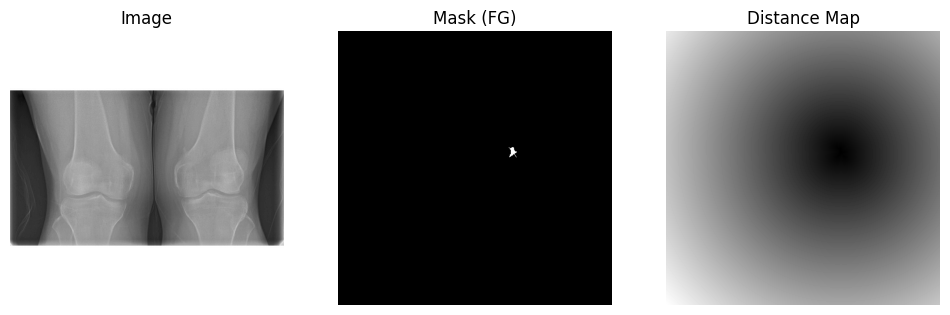

In [6]:
# =======================
# 4) Sanity check & viz
# =======================
for images, labels in train_dataset.take(1):
    print("Train batch shapes:", images.shape, labels['mask_output'].shape, labels['distance_output'].shape)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(images[0,...,0], cmap='gray'); plt.title("Image"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(labels['mask_output'][0,...,1], cmap='gray'); plt.title("Mask (FG)"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(labels['distance_output'][0,...,0], cmap='gray'); plt.title("Distance Map"); plt.axis('off')
    plt.show()
    break

In [7]:
# =======================
# 5) Model
# =======================
def segnet_multitask(input_shape=(512, 512, 1), num_classes=2):
    def conv_block(x, filters, dropout_rate=0.0):
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        if dropout_rate > 0:
            x = Dropout(dropout_rate)(x)
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        return x

    inputs = Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = MaxPooling2D()(c1)

    c2 = conv_block(p1, 64)
    p2 = MaxPooling2D()(c2)

    c3 = conv_block(p2, 128, 0.3)
    p3 = MaxPooling2D()(c3)

    c4 = conv_block(p3, 256, 0.3)
    p4 = MaxPooling2D()(c4)

    # Bottleneck
    bn = conv_block(p4, 512, 0.4)

    # Decoder + skip connections (không crop nữa)
    u4 = UpSampling2D()(bn)
    u4 = Concatenate()([u4, c4])
    c5 = conv_block(u4, 256, 0.3)

    u3 = UpSampling2D()(c5)
    u3 = Concatenate()([u3, c3])
    c6 = conv_block(u3, 128, 0.3)

    u2 = UpSampling2D()(c6)
    u2 = Concatenate()([u2, c2])
    c7 = conv_block(u2, 64)

    u1 = UpSampling2D()(c7)
    u1 = Concatenate()([u1, c1])
    c8 = conv_block(u1, 32)

    # Multi-task outputs
    mask_out = Conv2D(num_classes, 1, activation='softmax', name='mask_output')(c8)
    dist_out = Conv2D(1, 1, activation='tanh', name='distance_output')(c8)

    return Model(inputs, [mask_out, dist_out])


In [8]:
# =======================
# 6) Loss & metrics
# =======================
def weighted_dice_loss(y_true, y_pred, class_weights=[0.5,0.5], smooth=1e-6):
    loss = 0.0
    for i,w in enumerate(class_weights):
        yt = K.flatten(y_true[...,i]); yp = K.flatten(y_pred[...,i])
        inter = K.sum(yt*yp); union = K.sum(yt)+K.sum(yp)
        loss += w*(1-(2*inter+smooth)/(union+smooth))
    return loss

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred_hard = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=tf.shape(y_pred)[-1])
    inter = K.sum(y_true*y_pred_hard)
    union = K.sum(y_true)+K.sum(y_pred_hard)
    return (2*inter+smooth)/(union+smooth)

def iou_binary_from_onehot(y_true, y_pred, smooth=1e-6):
    y_true_fg = y_true[...,1]; y_pred_fg = tf.cast(tf.argmax(y_pred,axis=-1)==1,tf.float32)
    inter = tf.reduce_sum(y_true_fg*y_pred_fg)
    union = tf.reduce_sum(y_true_fg)+tf.reduce_sum(y_pred_fg)-inter
    return (inter+smooth)/(union+smooth)



In [9]:
# 7) Build model
# =======================
model = segnet_multitask(input_shape=(IMG_SIZE,IMG_SIZE,1))
plot_model(model, to_file='/kaggle/working/segnet_multitask_light.png', 
           show_shapes=True, show_layer_names=True)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 512, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 32)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 64)   │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 128, 128, 128)  │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 128)  │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 128, 128, 128)  │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization) 

 Total params: 7,857,923 (29.98 MB)

 Trainable params: 7,852,035 (29.95 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [10]:

# ======================
# 1. Config thời gian & wandb
# ======================
now_vn = datetime.now(ZoneInfo("Asia/Ho_Chi_Minh"))
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["WANDB_API_KEY"] = "0cc72a0b4220798e1847f8b28354bbd46e441792"  # API key

prj_name = "Unet_Distance_" + now_vn.strftime("%H:%M_%d/%m/%Y")

wandb.login()
wandb.init(
    project="SegNet_Multitask",
    name=prj_name,
    entity="unet-projects",
    config={
        "epochs": EPOCH,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "architecture": "SegNet-Multitask",
        "input_shape": (512, 512, 1),
        "num_classes": 2,
        "batch_size": BATCH_SIZE,
        "optimizer": "Adam",
        "loss_mask": "weighted_dice_loss",
        "loss_distance": "mse",
        "loss_weights": {
            "mask_output": 1.0,
            "distance_output": 0.5
        },
        "metrics_mask": ["dice_coef", "iou_binary_from_onehot"],
        "metrics_distance": ["mse"],
        "dataset": "BTXRD"
    }
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: trandonggiahan2003 (unet-projects) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [11]:
# ======================
# 2. Compile model
# ======================
model.compile(
    optimizer=optimizer,
    loss={
        "mask_output": weighted_dice_loss,
        "distance_output": "mse"
    },
    loss_weights={
        "mask_output": 1.0,
        "distance_output": 0.5
    },
    metrics={
        "mask_output": [dice_coef, iou_binary_from_onehot],
        "distance_output": ["mse"]
    }
)

In [12]:
# ======================
# 3. Custom callback log ảnh mask lên wandb
# ======================
class WandbImageLogger(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, num_samples=3):
        super().__init__()
        self.samples = list(val_dataset.unbatch().take(num_samples))

    def on_epoch_end(self, epoch, logs=None):
        images = []
        for img, (mask, dist) in self.samples:
            img_np = img.numpy()
            true_mask = np.argmax(mask.numpy(), axis=-1) if mask.shape[-1] > 1 else mask.numpy().squeeze()
            
            pred = self.model.predict(img[None, ...], verbose=0)
            pred_mask = np.argmax(pred[0], axis=-1).squeeze()

            images.append(
                wandb.Image(
                    img_np.squeeze(),
                    caption=f"Epoch {epoch+1}",
                    masks={
                        "true": {"mask_data": true_mask},
                        "pred": {"mask_data": pred_mask}
                    }
                )
            )
        wandb.log({"Examples": images}, step=epoch)



In [13]:
# ======================
# 4. Callbacks
# ======================
model_checkpoint = ModelCheckpoint(
    "/kaggle/working/segnet_best.keras", monitor="val_loss", save_best_only=True, verbose=1
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=5, min_lr=1e-7, verbose=1
)
wandb_cb = WandbCallback(save_model=True, save_graph=False)
wandb_img_logger = WandbImageLogger(val_dataset, num_samples=3)


wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [ ]:
# ======================
# 5. Fit model
# ======================
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCH,
    callbacks=[model_checkpoint, early_stopping, reduce_lr, wandb_cb, wandb_img_logger],
    verbose=1
)

Epoch 1/350


I0000 00:00:1755687039.312543      99 service.cc:148] XLA service 0x7b81c808de50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755687039.316493      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755687039.316514      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755687041.217599      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-20 10:50:47.026602: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[4,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_s

114/327 ━━━━━━━━━━━━━━━━━━━━ 1:24 395ms/step - distance_output_loss: 0.2800 - distance_output_mse: 0.2800 - loss: 0.7473 - mask_output_dice_coef: 0.6885 - mask_output_iou_binary_from_onehot: 0.0332 - mask_output_loss: 0.6073

**Config**

In [ ]:
results = model.evaluate(test_dataset)
print("📊 Test results:", results)